In [5]:
import requests
import pandas as pd
import numpy as np
from math import floor
from termcolor import colored as cl
import matplotlib.pyplot as plt

import glob
import os

In [3]:
plt.rcParams['figure.figsize'] = (20, 10)
plt.style.use('fivethirtyeight')

In [6]:
path = r'data/'                     # use your path
all_files = glob.glob(os.path.join(path, "*.csv"))     # advisable to use os.path.join as this makes concatenation OS independent

#df_from_each_file = (pd.read_csv(f) for f in all_files)
#concatenated_df   = pd.concat(df_from_each_file, ignore_index=True)


In [7]:
# NB SAMPLE
window = 20

for file in all_files:
    data = pd.read_csv(file)

    data = data.set_index('datetime')

print(data)
    

                           o        h        l        c            v
datetime                                                            
2020-11-19 01:00:00  0.03000  0.12000  0.03000  0.03777  713299610.3
2020-11-20 01:00:00  0.03776  0.04600  0.03350  0.03573  320411540.0
2020-11-21 01:00:00  0.03571  0.04000  0.03260  0.03791  282877391.0
2020-11-22 01:00:00  0.03790  0.04220  0.03519  0.04162  172188146.1
2020-11-23 01:00:00  0.04168  0.05450  0.03860  0.04704  334746436.4
...                      ...      ...      ...      ...          ...
2021-11-26 01:00:00  0.36201  0.36398  0.29700  0.31854  327945952.8
2021-11-27 01:00:00  0.31913  0.34297  0.30145  0.30630  151855460.4
2021-11-28 01:00:00  0.30629  0.35475  0.27082  0.32925  267870141.2
2021-11-29 01:00:00  0.32947  0.35758  0.30110  0.33017  250127675.9
2021-11-30 01:00:00  0.33000  0.34897  0.30188  0.30639  235830636.9

[377 rows x 5 columns]


In [13]:
def get_historical_data(symbol, start_date = None):
    api_key = open(r'api_key.txt')
    api_url = f'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY_ADJUSTED&symbol={symbol}&apikey={api_key}&outputsize=full'
    raw_df = requests.get(api_url).json()
    df = pd.DataFrame(raw_df[f'Time Series (Daily)']).T
    df = df.rename(columns = {'1. open': 'open', '2. high': 'high', '3. low': 'low', '4. close': 'close', '5. adjusted close': 'adj close', '6. volume': 'volume'})
    for i in df.columns:
        df[i] = df[i].astype(float)
    df.index = pd.to_datetime(df.index)
    df = df.iloc[::-1].drop(['7. dividend amount', '8. split coefficient'], axis = 1)
    if start_date:
        df = df[df.index >= start_date]
    return df

googl = get_historical_data('GOOGL', '2020-01-01')
googl

FileNotFoundError: [Errno 2] No such file or directory: 'api_key.txt'

In [9]:
def get_macd(price, slow, fast, smooth):
    #exponentialy moving average
    exp1 = price.ewm(span = fast, adjust = False).mean()
    exp2 = price.ewm(span = slow, adjust = False).mean()
    macd = pd.DataFrame(exp1 - exp2).rename(columns = {'c':'macd'})
    signal = pd.DataFrame(macd.ewm(span = smooth, adjust = False).mean()).rename(columns = {'macd':'signal'})
    hist = pd.DataFrame(macd['macd'] - signal['signal']).rename(columns = {0:'hist'})
    frames =  [macd, signal, hist]
    df = pd.concat(frames, join = 'inner', axis = 1)
    return df

googl_macd = get_macd(data['c'], 26, 12, 9)
googl_macd

,macd,signal,hist
datetime,,,
2020-11-19 01:00:00,0.000000,0.000000,0.000000
2020-11-20 01:00:00,-0.000163,-0.000033,-0.000130
2020-11-21 01:00:00,-0.000114,-0.000049,-0.000066
2020-11-22 01:00:00,0.000221,0.000005,0.000216
2020-11-23 01:00:00,0.000913,0.000187,0.000726
...,...,...,...
2021-11-26 01:00:00,0.044579,0.036449,0.008130
2021-11-27 01:00:00,0.039795,0.037118,0.002677
2021-11-28 01:00:00,0.037425,0.037180,0.000245


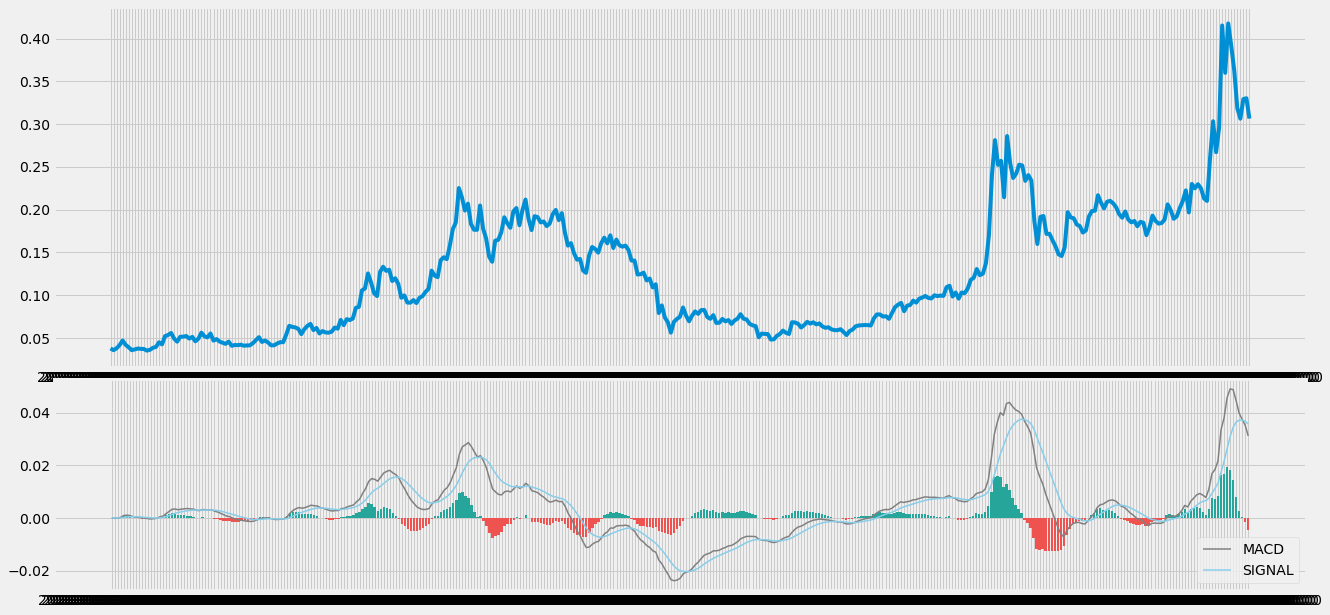

In [11]:
def plot_macd(prices, macd, signal, hist):
    ax1 = plt.subplot2grid((8,1), (0,0), rowspan = 5, colspan = 1)
    ax2 = plt.subplot2grid((8,1), (5,0), rowspan = 3, colspan = 1)

    ax1.plot(prices)
    ax2.plot(macd, color = 'grey', linewidth = 1.5, label = 'MACD')
    ax2.plot(signal, color = 'skyblue', linewidth = 1.5, label = 'SIGNAL')

    for i in range(len(prices)):
        if str(hist[i])[0] == '-':
            ax2.bar(prices.index[i], hist[i], color = '#ef5350')
        else:
            ax2.bar(prices.index[i], hist[i], color = '#26a69a')

    plt.legend(loc = 'lower right')

plot_macd(data['c'], googl_macd['macd'], googl_macd['signal'], googl_macd['hist'])

In [12]:
def implement_macd_strategy(prices, data):    
    buy_price = []
    sell_price = []
    macd_signal = []
    signal = 0

    for i in range(len(data)):
        if data['macd'][i] > data['signal'][i]:
            if signal != 1:
                buy_price.append(prices[i])
                sell_price.append(np.nan)
                signal = 1
                macd_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                macd_signal.append(0)
        elif data['macd'][i] < data['signal'][i]:
            if signal != -1:
                buy_price.append(np.nan)
                sell_price.append(prices[i])
                signal = -1
                macd_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                macd_signal.append(0)
        else:
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            macd_signal.append(0)
            
    return buy_price, sell_price, macd_signal

buy_price, sell_price, macd_signal = implement_macd_strategy(data['c'], googl_macd)

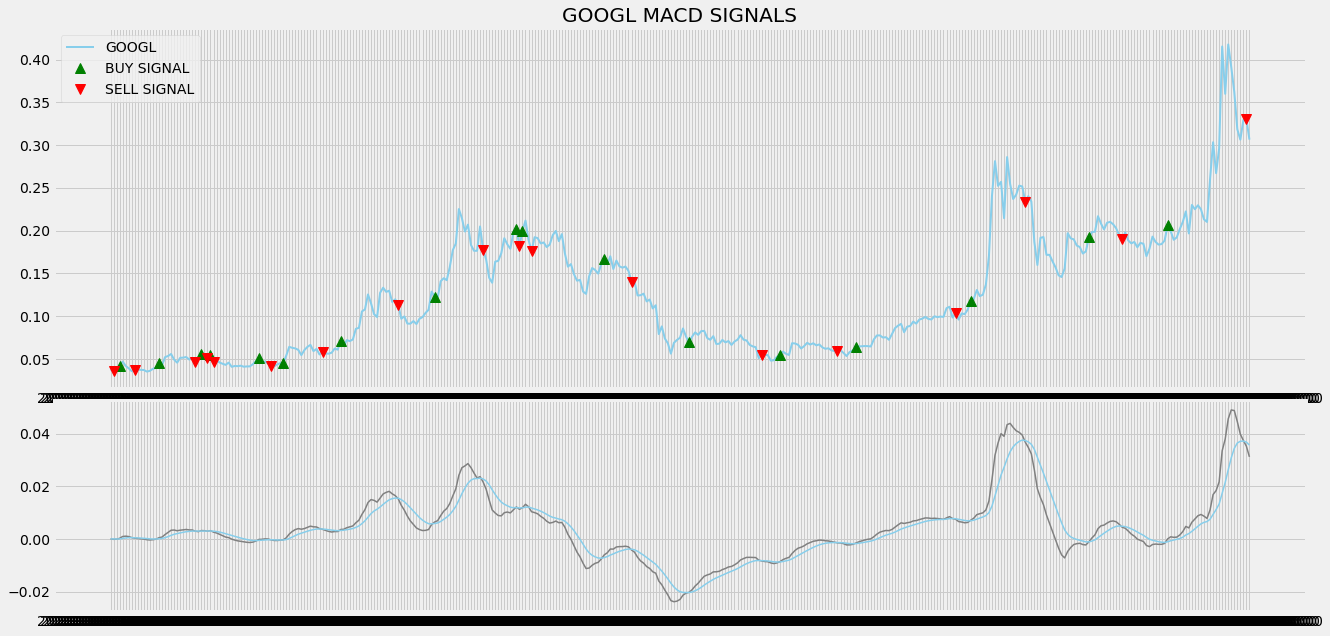

In [14]:
ax1 = plt.subplot2grid((8,1), (0,0), rowspan = 5, colspan = 1)
ax2 = plt.subplot2grid((8,1), (5,0), rowspan = 3, colspan = 1)

ax1.plot(data['c'], color = 'skyblue', linewidth = 2, label = 'GOOGL')
ax1.plot(data.index, buy_price, marker = '^', color = 'green', markersize = 10, label = 'BUY SIGNAL', linewidth = 0)
ax1.plot(data.index, sell_price, marker = 'v', color = 'r', markersize = 10, label = 'SELL SIGNAL', linewidth = 0)
ax1.legend()
ax1.set_title('GOOGL MACD SIGNALS')
ax2.plot(googl_macd['macd'], color = 'grey', linewidth = 1.5, label = 'MACD')
ax2.plot(googl_macd['signal'], color = 'skyblue', linewidth = 1.5, label = 'SIGNAL')